In [6]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.io import fits as fits
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
sys.path.append('../modules/')
import _analysis_cluster_mass_measurement as analysisM
sys.path.append('../../')
import _redshift_richness_bins as analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dat = fits.open('../../data/matched_pairs_Mfofcut.fits')
dat_open= dat[1].data

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


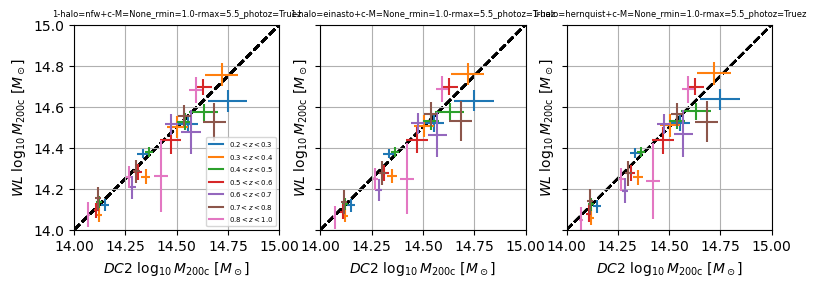

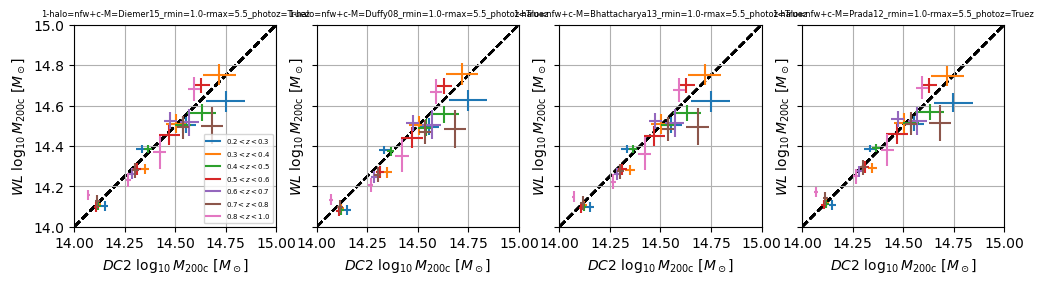

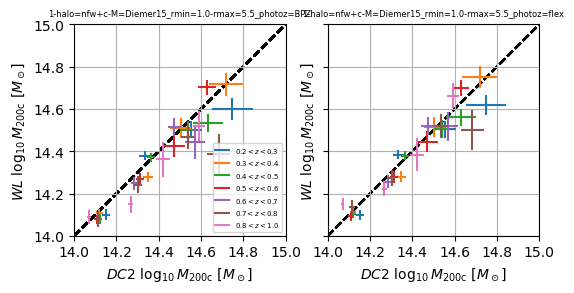

In [3]:
m = np.linspace(14, 15, 10)
color = ['C' + str(i) for i in range(len(analysis.Z_bin))]
for case in analysisM.analysis.keys():
    analysis_list = analysisM.analysis[case]
    if len(analysis_list)==1: continue
    fig, ax = plt.subplots(1, len(analysis_list),figsize=(3*len(analysis_list), 3), sharex=True, sharey=True)
    for i in range(len(analysis_list)):
        file_to_load = analysis_list[i]['name_save']
        f = Table(np.load(file_to_load, allow_pickle = True)['masses'])
        for k, z_bin in enumerate(analysis.Z_bin):
            if i==0:
                ax[0].plot([],[], '-',label = f'{z_bin[0]:.1f}'+ r'$< z < $'+ f'{z_bin[1]:.1f}', color = color[k])
                ax[0].legend(fontsize=5, loc = 'lower right')
            for l, r_bin in enumerate(analysis.Obs_bin):
                file_to_load = analysis_list[i]['name_save']
                mask_z = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
                mask_r = (f['obs_mean'] > r_bin[0])*(f['obs_mean'] < r_bin[1])
                mask = mask_z * mask_r
                f_cut = f[mask]
                richness = f_cut['obs_mean']
                richness_err = f_cut['obs_rms']
                logm200w = f_cut['log10M200c_WL']
                logm200w_err = f_cut['err_log10M200c_WL']
                mask_z = (dat_open['cat1_ztrue_cg'] > z_bin[0])*(dat_open['cat1_ztrue_cg'] < z_bin[1])
                mask_r = (dat_open['cat1_richness'] > r_bin[0])*(dat_open['cat1_richness'] < r_bin[1])
                mask = mask_z * mask_r
                ax[i].set_ylim(14, 15)
                ax[i].set_xlim(14, 15)
                mean_logm_true = np.log10(np.mean(dat_open['cat2_M200c'][mask]))
                mean_logm_true_err = np.std(np.log10(dat_open['cat2_M200c'][mask]))/np.sqrt(len(mask[mask==True]))
                ax[i].errorbar(mean_logm_true, logm200w, yerr=logm200w_err, xerr=mean_logm_true_err, color = color[k])
                ax[i].plot(m, m, '--k', zorder=0)
                ax[i].set_ylabel(r'$WL\ \log_{10}M_{\rm 200c}\ [M_\odot]$', fontsize=10)
                ax[i].set_xlabel(r'$DC2\ \log_{10}M_{\rm 200c}\ [M_\odot]$', fontsize=10)
                title = file_to_load.split('../../cluster_mass_measurement/cluster-masses_')[1].split('.pkl')[0]
                ax[i].set_title(title, fontsize=6)
                ax[i].set_box_aspect(aspect=1)
                ax[i].grid(True)
    plt.savefig(f'../../fig/cluster_masses_DC2_vs_lensing_impact_{case}.png', bbox_inches='tight', dpi=300)

halo_model
     mask      ...
-------------- ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
           ... ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
False .. False ...
Length = 28 rows
1
1
cM_relation
2h
photoz


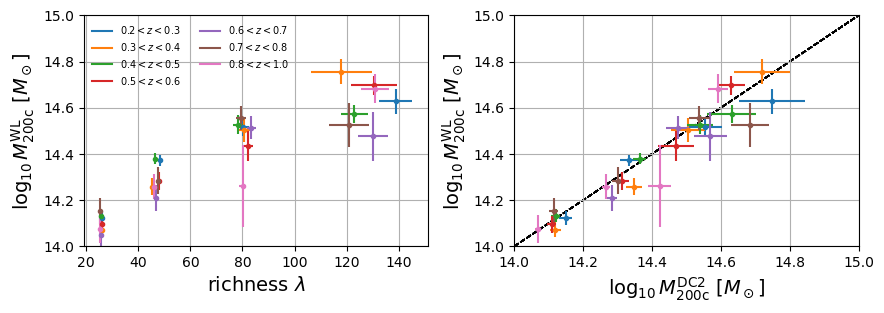

In [21]:
m = np.linspace(14, 15, 10)
color = ['C' + str(i) for i in range(len(analysis.Z_bin))]
for case in analysisM.analysis.keys():
    print(case)
    if case != 'halo_model': 
        continue
    analysis_list = analysisM.analysis[case]
    if len(analysis_list)==1: continue
    fig, ax = plt.subplots(1, 2,figsize=(10,3),)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=None)
    for i in range(len(analysis_list)):
        file_to_load = analysis_list[i]['name_save']
        title = file_to_load.split('../../cluster_mass_measurement/cluster-masses_')[1].split('.pkl')[0]
        if title != '1-halo=nfw+c-M=None_rmin=1.0-rmax=5.5_photoz=Truez': 
            print(1)
            continue
        f = Table(np.load(file_to_load, allow_pickle = True)['masses'])
        print(f)
        for k, z_bin in enumerate(analysis.Z_bin):
            if i==0:
                ax[0].plot([],[], '-',label = f'{z_bin[0]:.1f}'+ r'$< z < $'+ f'{z_bin[1]:.1f}', color = color[k])
                ax[0].legend(fontsize=7, loc = 'upper left', ncols=2, frameon=False)
            for l, r_bin in enumerate(analysis.Obs_bin):
                file_to_load = analysis_list[i]['name_save']
                mask_z = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
                mask_r = (f['obs_mean'] > r_bin[0])*(f['obs_mean'] < r_bin[1])
                mask = mask_z * mask_r
                f_cut = f[mask]
                richness = f_cut['obs_mean']
                richness_err = f_cut['obs_rms']
                logm200w = f_cut['log10M200c_WL']
                logm200w_err = f_cut['err_log10M200c_WL']
                ax[0].errorbar(richness, logm200w, yerr=logm200w_err, xerr=richness_err, color = color[k], marker='.', )
                ax[0].grid(True)
                ax[0].set_ylim(14, 15)
                ax[0].set_ylabel(r'$\log_{10}M_{\rm 200c}^{\rm WL}\ [M_\odot]$', fontsize=14)
                ax[0].set_xlabel(r'richness $\lambda$', fontsize=14)
                
                
                mask_z = (dat_open['cat1_ztrue_cg'] > z_bin[0])*(dat_open['cat1_ztrue_cg'] < z_bin[1])
                mask_r = (dat_open['cat1_richness'] > r_bin[0])*(dat_open['cat1_richness'] < r_bin[1])
                mask = mask_z * mask_r
                mean_logm_true = np.log10(np.mean(dat_open['cat2_M200c'][mask]))
                mean_logm_true_err = np.std(np.log10(dat_open['cat2_M200c'][mask]))/np.sqrt(len(mask[mask==True]))
                ax[1].errorbar(mean_logm_true, logm200w, yerr=logm200w_err, xerr=mean_logm_true_err, color = color[k], marker='.')
                ax[1].plot(m, m, '--k', zorder=0, lw=1)
                ax[1].set_ylabel(r'$\log_{10}M_{\rm 200c}^{\rm WL}\ [M_\odot]$', fontsize=14)
                ax[1].set_xlabel(r'$\log_{10}M_{\rm 200c}^{\rm DC2}\ [M_\odot]$', fontsize=14)
                title = file_to_load.split('../../cluster_mass_measurement/cluster-masses_')[1].split('.pkl')[0]
                ax[1].grid(True)
                ax[1].set_ylim(14, 15)
                ax[1].set_xlim(14, 15)
plt.savefig(f'../../fig/cluster_masses_paper.png', bbox_inches='tight', dpi=300)